### Data Loader

In [1]:
import pandas as pd
plasma_data = pd.read_csv("OhNM2025_ROSMAP_plasma_Soma7k_protein_level_log10.csv")
plasma_data.shape

(973, 7290)

In [2]:
phenotype_data = pd.read_csv("OhNM2025_ROSMAP_plasma_Soma7k_sample_metadata.csv")
phenotype_data.shape

(973, 20)

In [3]:
# phenotype_data

In [4]:
merged_data = pd.merge(plasma_data, phenotype_data, on='projid_visit', how='left')
# merged_data

In [5]:
import pandas as pd

summary_list = []

for diagnosis, group in merged_data.groupby('Diagnosis'):
    n_total = group['projid_visit'].nunique()
    n_female = group[group['msex'] == 0]['projid'].nunique()
    female_percent = (n_female / n_total) * 100 if n_total > 0 else 0

    age_mean = group['age_at_visit'].mean()
    age_std = group['age_at_visit'].std()

    summary_list.append({
        'Diagnosis': diagnosis,
        'N': n_total,
        'Female (%)': f"{n_female} ({female_percent:.2f}%)",
        'Age Mean (SD)': f"{age_mean:.1f} ({age_std:.1f})"
    })

summary_df = pd.DataFrame(summary_list).sort_values(by='Diagnosis')

print(summary_df)

  Diagnosis    N    Female (%) Age Mean (SD)
0        AD  167  118 (70.66%)    87.8 (6.2)
1       AD+   17   11 (64.71%)    90.5 (4.4)
2       MCI  262  178 (67.94%)    86.9 (6.2)
3      MCI+   10    5 (50.00%)    86.0 (7.4)
4       NCI  507  335 (66.07%)    84.6 (6.2)
5   OthrDem   10    6 (60.00%)    86.7 (4.8)


In [6]:
import pandas as pd
import re

def rename_columns(df):
    new_columns = []
    for col in df.columns:
        if re.match(r'^\d+-\d+$', col):
            new_col = 'X' + col.replace('-', '.')
        else:
            new_col = col
        new_columns.append(new_col)
    df.columns = new_columns
    return df

merged_data = rename_columns(merged_data)

In [7]:
# merged_data

In [8]:
from scipy.stats import zscore
x_cols = [col for col in merged_data.columns if col.startswith('X')]
merged_data[x_cols] = merged_data[x_cols].apply(zscore, nan_policy='omit')

In [9]:
# merged_data

### Modelling

In [12]:
filtered_data = merged_data.copy()

In [13]:
import joblib
csf_lgbm_model = joblib.load("plasma_model_output/plasma_lgbm_model_700_0411.pkl")

In [14]:
with open("plasma_model_output/plasma_selected_features_700_0411.txt", "r") as f:
    csf_selected_features = [line.strip() for line in f.readlines()]

csf_selected_features.append('Diagnosis')

existing_features = [feature for feature in csf_selected_features if feature in filtered_data.columns]

selected_data = filtered_data[existing_features]

print(f"Total selected features: {len(csf_selected_features)}")
print(f"Existing features in dataset: {len(existing_features)}")

Total selected features: 701
Existing features in dataset: 701


In [15]:
selected_data['Diagnosis'].value_counts()

Diagnosis
NCI        507
MCI        262
AD         167
AD+         17
MCI+        10
OthrDem     10
Name: count, dtype: int64

In [16]:
X_new = selected_data.iloc[:, :-1]
print(X_new.shape)

X_new_log10_zscore = X_new

y_pred = csf_lgbm_model.predict(X_new)
y_pred_proba = csf_lgbm_model.predict_proba(X_new)

print("Predicted Labels:", y_pred)
print("Predicted Probabilities:\n", y_pred_proba)

(973, 700)
Predicted Labels: [1 0 1 1 0 0 1 1 0 0 4 1 1 1 1 0 1 1 0 1 1 1 4 1 1 2 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 4 1 1 1 1 1 1 0 1 1 1 1 1 0 1 4 2 1 2 1 0 4 0 1 0 1 1 1 1 1 0 1 0
 1 1 0 1 1 0 1 2 1 0 0 4 4 1 1 1 1 0 1 1 1 1 0 1 1 0 4 0 1 1 1 0 1 0 4 1 1
 4 1 0 1 4 1 1 1 0 1 1 0 1 1 1 1 1 4 4 1 4 0 1 1 2 0 1 1 1 0 1 0 1 1 1 4 0
 1 1 0 0 1 1 4 1 1 2 1 1 1 1 4 0 1 0 1 1 1 4 4 1 0 0 0 0 0 1 4 1 2 0 0 1 4
 4 4 0 4 0 4 0 0 0 2 0 0 1 1 1 1 1 1 1 2 1 4 1 4 4 0 2 4 1 1 1 4 1 1 1 1 4
 1 1 1 0 1 1 2 0 1 1 0 1 1 2 1 1 0 0 0 1 1 2 0 1 0 1 0 1 0 1 1 0 0 1 1 4 1
 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 2 1 0 1 1 1 1 0 0 4 1 1 1 4
 1 4 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 4 2 0 0 0 1 1 1 1 0 1 4 0 1 4
 1 1 2 0 0 0 2 4 1 0 0 1 1 0 0 1 1 1 0 1 4 0 1 3 1 1 1 1 0 1 1 1 2 0 1 0 4
 1 1 1 1 0 1 1 4 1 2 1 1 1 2 3 1 1 1 1 0 0 0 2 1 1 1 1 1 4 1 4 3 4 0 4 0 1
 4 1 0 0 1 4 1 4 1 1 1 1 2 0 1 1 1 1 1 0 0 0 0 1 1 2 1 4 1 0 1 0 1 0 1 1 1
 0 0 1 4 0 1 1 0 4 1 4 0 0 1 1 2 1 1 1 1 4 1 4 1 4 0 1 1 1 1 1 0 0 4 2 

In [17]:
UniquePhenoID = filtered_data['projid_visit']
status_labels = selected_data['Diagnosis'].str.upper()
y_pred_proba_df = pd.DataFrame(y_pred_proba, index=status_labels.index, columns=[f"{label} Probability" for label in ['AD', 'CO', 'DLB', 'FTD', 'PD']])

predicted_classes = y_pred_proba_df.idxmax(axis=1).str.replace(' Probability', '')

results_df = pd.DataFrame({
    "UniquePhenoID": UniquePhenoID,
    "Status_at_draw": status_labels,
    "Predicted Class": predicted_classes
    # "Predicted Class": label_encoder.inverse_transform(y_pred)
})

results_df = pd.concat([results_df, y_pred_proba_df], axis=1)
results_df

# results_df.to_csv("ROSMAP_Plasma_973_Prediction_Results_700.csv", index=False)

,UniquePhenoID,Status_at_draw,Predicted Class,AD Probability,CO Probability,DLB Probability,FTD Probability,PD Probability
0,86177506_01,MCI,CO,0.236741,0.734102,0.000407,0.000981,0.027768
1,46369736_02,AD+,AD,0.719794,0.246170,0.019001,0.000081,0.014953
2,50402855_13,NCI,CO,0.000144,0.999195,0.000107,0.000012,0.000542
3,20267709_03,AD,CO,0.051487,0.907538,0.000393,0.000119,0.040463
4,77743003_00,AD,AD,0.797805,0.039519,0.031934,0.000653,0.130090
...,...,...,...,...,...,...,...,...
968,20544321_09,NCI,AD,0.983150,0.013625,0.002461,0.000038,0.000726
969,50107871_06,AD,AD,0.978746,0.000373,0.000759,0.000004,0.020119
970,94430339_02,MCI,AD,0.927282,0.013826,0.053146,0.000176,0.005571
971,52064033_03,NCI,PD,0.018250,0.430157,0.001164,0.000393,0.550037


In [18]:
results_df.columns

Index(['UniquePhenoID', 'Status_at_draw', 'Predicted Class', 'AD Probability',
       'CO Probability', 'DLB Probability', 'FTD Probability',
       'PD Probability'],
      dtype='object')

In [19]:
results_df['Status_at_draw'].value_counts()

Status_at_draw
NCI        507
MCI        262
AD         167
AD+         17
MCI+        10
OTHRDEM     10
Name: count, dtype: int64

In [20]:
import pandas as pd

conf_matrix = pd.crosstab(results_df['Status_at_draw'], results_df['Predicted Class'], 
                          rownames=['True Label'], colnames=['Predicted Label'])

print(conf_matrix)

Predicted Label  AD   CO  DLB  FTD  PD
True Label                            
AD               97   42    6    1  21
AD+               7    5    0    0   5
MCI              86  115   15    1  45
MCI+              2    6    1    0   1
NCI              84  328   20    4  71
OTHRDEM           1    5    1    0   3



=== Confusion-derived metrics (AD vs CO) ===
  Class  TP  FN  FP   TN  Sensitivity  Specificity  Accuracy
0    AD  97  42  84  328        0.698        0.796     0.771


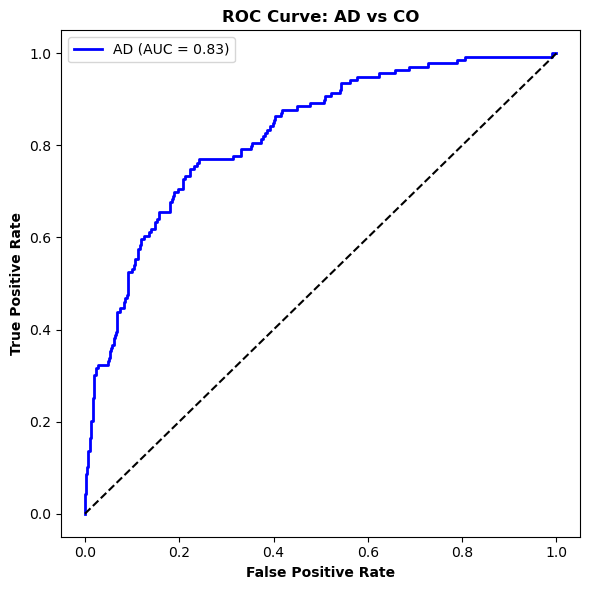

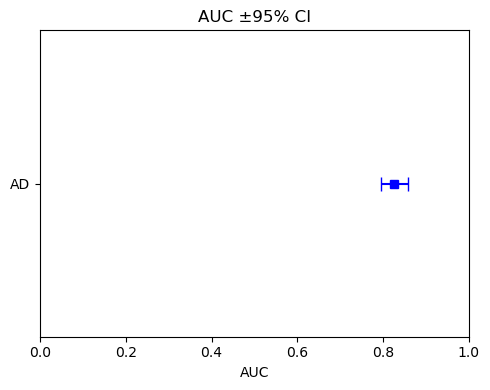

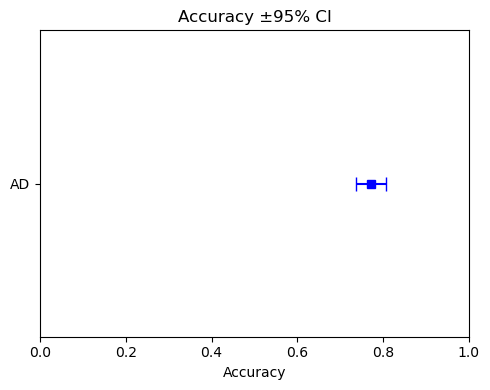


=== Summary (AD vs CO) ===
AUC:        0.826  (95% CI 0.79–0.86)
Accuracy:   0.771      (95% CI 0.736–0.806)
Sensitivity:0.698
Specificity:0.796


In [21]:
# -----------------------------------------------------------
# ★  Input: results_df (contains true/predicted labels & probabilities)
# -----------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from matplotlib.lines import Line2D

# 1) Map ground truth labels; keep only AD and CO samples -----
mapping = {'AD': 'AD', 'NCI': 'CO'}
results_bin = results_df.copy()
results_bin['TrueBin'] = results_bin['Status_at_draw'].map(mapping)
results_bin = results_bin.dropna(subset=['TrueBin'])  # Drop rows with other labels

# 2) Filter predictions; keep only AD and CO -------------------
results_bin = results_bin[results_bin['Predicted Class'].isin(['AD', 'CO'])]

# 3) Prepare true labels, predicted labels, and probabilities --
label_encoder = LabelEncoder().fit(['AD', 'CO'])
y_true_lbl = results_bin['TrueBin'].values
y_pred_lbl = results_bin['Predicted Class'].values

# Extract probability of AD class
if 'AD Probability' in results_bin.columns and 'CO Probability' in results_bin.columns:
    prob_AD = results_bin['AD Probability'].values
else:  # Only AD probability is available
    prob_AD = results_bin['AD Probability'].values

# Construct probability matrix: shape (n_samples × 2)
results_bin_proba = np.vstack([prob_AD, 1 - prob_AD]).T

# -----------------------------------------------------------
# 4) Binary classification confusion matrix & metrics ---------
TP = np.sum((y_pred_lbl == 'AD') & (y_true_lbl == 'AD'))
FP = np.sum((y_pred_lbl == 'AD') & (y_true_lbl == 'CO'))
FN = np.sum((y_pred_lbl == 'CO') & (y_true_lbl == 'AD'))
TN = np.sum((y_pred_lbl == 'CO') & (y_true_lbl == 'CO'))
N  = TP + FP + FN + TN

sens = TP / (TP + FN) if TP + FN else np.nan
spec = TN / (TN + FP) if TN + FP else np.nan
acc  = (TP + TN) / N

print("\n=== Confusion-derived metrics (AD vs CO) ===")
print(pd.DataFrame([dict(Class='AD', TP=TP, FN=FN, FP=FP, TN=TN,
                         Sensitivity=round(sens, 3),
                         Specificity=round(spec, 3),
                         Accuracy=round(acc, 3))]))

# -----------------------------------------------------------
# 5) ROC curve and AUC calculation ----------------------------
y_true_bin = (y_true_lbl == 'AD').astype(int)
fpr, tpr, _ = roc_curve(y_true_bin, prob_AD)
auc_val     = auc(fpr, tpr)
se_auc      = np.sqrt((auc_val * (1 - auc_val)) / N)
ci_low, ci_up = auc_val - 1.96 * se_auc, auc_val + 1.96 * se_auc

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AD (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlabel('False Positive Rate', weight='bold')
plt.ylabel('True Positive Rate', weight='bold')
plt.title('ROC Curve: AD vs CO', weight='bold')
plt.grid(False); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------------------------------------
# 6) AUC and Accuracy with 95% Confidence Intervals -----------
# —— AUC CI plot
plt.figure(figsize=(5, 4))
plt.errorbar(auc_val, ['AD'], xerr=[[auc_val - ci_low], [ci_up - auc_val]],
             fmt='s', color='blue', capsize=5)
plt.xlim(0, 1); plt.xlabel('AUC'); plt.title('AUC ±95% CI'); plt.grid(False)
plt.tight_layout(); plt.show()

# —— Accuracy CI plot
se_acc   = np.sqrt(acc * (1 - acc) / N)
ci_low_a = acc - 1.96 * se_acc
ci_up_a  = acc + 1.96 * se_acc
plt.figure(figsize=(5, 4))
plt.errorbar(acc, ['AD'], xerr=[[acc - ci_low_a], [ci_up_a - acc]],
             fmt='s', color='blue', capsize=5)
plt.xlim(0, 1); plt.xlabel('Accuracy'); plt.title('Accuracy ±95% CI'); plt.grid(False)
plt.tight_layout(); plt.show()

# -----------------------------------------------------------
# 7) Print performance summary --------------------------------
print("\n=== Summary (AD vs CO) ===")
print(f"AUC:        {auc_val:.3f}  (95% CI {ci_low:.2f}–{ci_up:.2f})")
print(f"Accuracy:   {acc:.3f}      (95% CI {ci_low_a:.3f}–{ci_up_a:.3f})")
print(f"Sensitivity:{sens:.3f}")
print(f"Specificity:{spec:.3f}")
